In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandahouse as ph
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [28]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

# Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [29]:
query = '''
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2023-01-31' and '2023-02-06'
and exp_group in (0,3)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)

In [30]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,3,123580,13,48,0.270833
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,18,88,0.204545


In [31]:
control_ctr = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()

In [32]:
df['linearized_likes'] = df['likes'] - control_ctr*df['views']

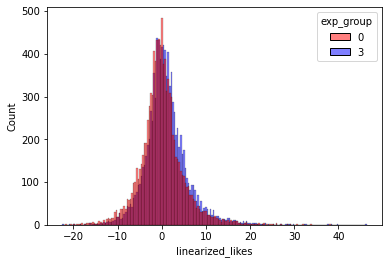

In [33]:
# Распределение линеаризированных лайков
groups_linear = sns.histplot(data = df,
x='linearized_likes',
hue='exp_group',
palette = ['r', 'b'],
alpha=0.5,
kde=False)

Кажется, метрика в группе 3 больше, чем в группе 0

In [34]:
# Т-тест по метрике обычных CTR
stats.ttest_ind(df[df.exp_group == 0].ctr,
df[df.exp_group == 3].ctr,
equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

In [35]:
# Т-тест по метрике линеаризированных лайков
stats.ttest_ind(df[df.exp_group == 0].linearized_likes,
df[df.exp_group == 3].linearized_likes,
equal_var=False)

Ttest_indResult(statistic=-15.21499546090383, pvalue=5.4914249479687664e-52)

Оба теста показали наличие стат.значимых различий, однако p-value при использовании Т-теста на линеаризованных лайках оказался еще меньше, чем при проведении Т-теста на обычных CTR.
Это означает, что при тех же различиях в исходном CTR мы с большей вероятостью обнаружим изменения при использовании линеаризованной метрики.


# Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [39]:
query = '''
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2023-01-31' and '2023-02-06'
and exp_group in (1,2)
GROUP BY exp_group, user_id
'''

df_1 = ph.read_clickhouse(query, connection=connection)

In [41]:
control_ctr_1 = df_1[df_1.exp_group == 1].likes.sum()/df_1[df_1.exp_group == 1].views.sum()

In [43]:
df_1['linearized_likes'] = df_1['likes'] - control_ctr_1*df_1['views']

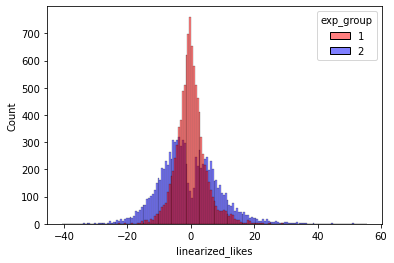

In [44]:
# Распределение линеаризированных лайков
groups_linear = sns.histplot(data = df_1,
x='linearized_likes',
hue='exp_group',
palette = ['r', 'b'],
alpha=0.5,
kde=False)

In [45]:
# Т-тест по метрике линеаризированных лайков
stats.ttest_ind(df_1[df_1.exp_group == 1].linearized_likes,
df_1[df_1.exp_group == 2].linearized_likes,
equal_var=False)

Ttest_indResult(statistic=6.122579994775973, pvalue=9.439432187037712e-10)

In [46]:
# Т-тест по метрике CTR
stats.ttest_ind(df_1[df_1.exp_group == 1].ctr,
df_1[df_1.exp_group == 2].ctr,
equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

В отличие Т-теста на обычных CTR, тест на линеаризованной метрике показал наличие стат.значимых различий, которые можно наблюдать и на графике